In [ ]:
from transformers import AutoModel, AutoTokenizer, pipeline
import torch
import torch.functional as F
import torch.nn as nn

import math
import numpy as np

from tqdm import tqdm, trange

## use pretrained from hf

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-multilingual-cased')
model = AutoModel.from_pretrained('google-bert/bert-base-multilingual-cased')

In [ ]:
inp_text = 'hello, it was so crazy to see you here'
inp_text_tokenized = tokenizer(inp_text, padding=True, truncation=True, return_tensors="pt")
inp_text_tokenized

{'input_ids': tensor([[  101, 61694, 10133,   117, 10271, 10134, 10380,   171, 29948, 10157,
         10114, 12888, 13028, 19353,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
model(inp_text_tokenized['input_ids'])['pooler_output']

In [ ]:
a = tokenizer(inp_text)

In [ ]:
a

{'input_ids': [101, 61694, 10133, 117, 10271, 10134, 10380, 171, 29948, 10157, 10114, 12888, 13028, 19353, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
class MyBert(nn.Module):
  def __init__(self):
    super().__init__()
    self.tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-multilingual-cased')
    self.model = AutoModel.from_pretrained('google-bert/bert-base-multilingual-cased')
    self.out = nn.Linear(768, 2) # good or bad (sentiment-analysis), just toy example

  def forward(self, inp):
    tokenized_text = self.tokenizer(inp, return_tensors='pt', padding=True, truncation=True)
    out = self.out(self.model(tokenized_text['input_ids'])["pooler_output"])
    return out

In [ ]:
mybert = MyBert()
optimizer = torch.optim.AdamW(mybert.parameters())

epochs = 10

In [ ]:
inp_text = 'hello, it was so crazy to see you here'

In [ ]:
for i in trange(epochs):
  optimizer.zero_grad()
  logits = mybert(inp_text)
  loss = torch.nn.functional.cross_entropy(logits, torch.tensor([1])) # let's suppose input text is positive (1)
  loss.backward()
  optimizer.step()
  print(loss.item())

 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

0.7674217224121094


 20%|██        | 2/10 [00:04<00:18,  2.34s/it]

0.10227975994348526


 30%|███       | 3/10 [00:07<00:18,  2.59s/it]

0.001128394273109734


 40%|████      | 4/10 [00:09<00:14,  2.42s/it]

5.531158240046352e-05


 50%|█████     | 5/10 [00:11<00:11,  2.27s/it]

1.5258672647178173e-05


 60%|██████    | 6/10 [00:13<00:08,  2.18s/it]

4.768360213347478e-06


 70%|███████   | 7/10 [00:15<00:06,  2.12s/it]

1.7881377516459906e-06


 80%|████████  | 8/10 [00:17<00:04,  2.08s/it]

8.344646857949556e-07


 90%|█████████ | 9/10 [00:20<00:02,  2.28s/it]

4.768370445162873e-07


100%|██████████| 10/10 [00:22<00:00,  2.26s/it]

3.576278118089249e-07


## my own transformer

In [ ]:
# СУПЕР ВАЖНО НЕ МЕНЯТЬ НИГДЕ НАЗВАНИЯ В САМОМ ТРАНСФОРМЕРЕ И В ДРУГИХ КЛАССАХ НУЖНЫХ ДЛЯ НЕГО
# ДЕЛО В ТОМ, ЧТО В GPT2 ТАКИЕ НАЗВАНИЯ СЛОЕВ, А МЫ ЗАГРУЖАЕМ ВЕСА ДЛЯ НЕЕ

In [ ]:
from huggingface_hub import hf_hub_download
state_dict = torch.load(hf_hub_download("gpt2", filename="pytorch_model.bin"))
for key, value in tuple(state_dict.items()):
    if key.startswith('h.') and key.endswith('.weight') and value.ndim == 2:
        value.transpose_(1, 0)  # <-- for compatibility with modern PyTorch modules
    if key.startswith('h.') and key.endswith('.attn.bias') and value.ndim == 4:
        state_dict.pop(key)  # <-- triangular binar masks, not needed in this code

print('Weights:', repr(sorted(state_dict.keys()))[:320], '...')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

Weights: ['h.0.attn.c_attn.bias', 'h.0.attn.c_attn.weight', 'h.0.attn.c_proj.bias', 'h.0.attn.c_proj.weight', 'h.0.ln_1.bias', 'h.0.ln_1.weight', 'h.0.ln_2.bias', 'h.0.ln_2.weight', 'h.0.mlp.c_fc.bias', 'h.0.mlp.c_fc.weight', 'h.0.mlp.c_proj.bias', 'h.0.mlp.c_proj.weight', 'h.1.attn.c_attn.bias', 'h.1.attn.c_attn.weight', 'h.1. ...


In [ ]:
class GeLUThatWasUsedInGPT2(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * x ** 3)))

class FullyConnected(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.c_fc = nn.Linear(dim, 4  * dim)
        self.gelu = GeLUThatWasUsedInGPT2()
        self.c_proj = nn.Linear(4 * dim, dim)

    def forward(self, x):
        # x.shape = [batch_size, seq_length, dim]
        out = self.gelu(self.c_fc(x))
        out = self.c_proj(out)
        return out # [batch_size, sequence_length, dim]

In [ ]:
mlp = FullyConnected(dim=768)
mlp.load_state_dict({'c_fc.weight': state_dict['h.0.mlp.c_fc.weight'],
                     'c_fc.bias': state_dict['h.0.mlp.c_fc.bias'],
                     'c_proj.weight': state_dict['h.0.mlp.c_proj.weight'],
                     'c_proj.bias': state_dict['h.0.mlp.c_proj.bias']})

torch.manual_seed(1337)
x = torch.randn(1, 2, 768)  # [batch_size, sequence_length, dim]
checksum = torch.sum(mlp(x) * x)
assert abs(checksum.item() - 1282.3315) < 0.1, "layer outputs do not match reference"
assert torch.allclose(mlp(x[:, (1, 0), :])[:, (1, 0), :], mlp(x)), "mlp must be permutation-invariant"
print("Seems legit!")

Seems legit!


In [ ]:
class Scaled_dot_product_attention(nn.Module):
  def __init__(self):
    super().__init__()
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, q, k, v, mask=None):
    # [batch_size, head, length, dim_tensor]
    k_t = k.transpose(2, 3)
    score = (q @ k_t) / math.sqrt(v.shape[-1])

    if mask is not None:
      score = score.masked_fill(mask == 0, -10000)
      # значения, где маска == 0 заменятся на -10000, что в софтмаксе даст почти ничего

    score = self.softmax(score)
    v = score @ v

    return v, score

In [ ]:
class MaskedSelfAttention(nn.Module):
    def __init__(self, dim: int, num_heads: int):
        super().__init__()
        self.c_attn = nn.Linear(dim, dim * 3)  # query + key + value, combined
        self.c_proj = nn.Linear(dim, dim)  # output projection
        self.dim, self.num_heads = dim, num_heads
        self.head_size = dim // num_heads
        self.attn = Scaled_dot_product_attention()

    def forward(self, x):
        q, k, v = self.c_attn(x).split(dim=-1, split_size=self.dim)
        assert q.shape == k.shape == v.shape == x.shape, "q, k and v must have the same shape as x"

        q, k, v = self.split(q), self.split(k), self.split(v)
        # q=, k=, v = [batch_size, head, length, dim_tensor]

        out, score = self.attn(q, k, v, mask=self.get_mask(q)) # [batch_size, head, length, dim_tensor]

        out = self.concat(out)
        out = self.c_proj(out) # [batch_size, length, dim_model]

        return out

    def split(self, tensor):
        """
        split tensor by number of head

        :param tensor: [batch_size, length, dim_model]
        :return: [batch_size, head, length, dim_tensor]
        """
        batch_size, length, dim_model = tensor.size()

        dim_tensor = dim_model // self.num_heads
        tensor = tensor.view(batch_size, length, self.num_heads, dim_tensor).transpose(1, 2)

        return tensor

    def concat(self, tensor):
        """
        inverse function of self.split(tensor : torch.Tensor)

        :param tensor: [batch_size, head, length, dim_tensor]
        :return: [batch_size, length, dim_model]
        """
        batch_size, head, length, dim_tensor = tensor.size()
        dim_model = head * dim_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, dim_model)
        return tensor

    def get_mask(self, x):
        """
        создаем маску, которая будет иметь значение 0 для позиций, к которым не следует обращать внимание
        в данном случае, мы создаем маску, которая будет иметь значение 0 для элементов, которые еще не были обработаны
        (для элементов в будущем относительно текущего элемента)

        :param tensor: [batch_size, head, length, dim_tensor]
        :return: [batch_size, 1, length, length]
        """
        batch_size, length = x.size(0), x.size(2)
        mask = torch.ones((batch_size, 1, length, length), device=x.device)
        mask = torch.tril(mask) # заполняем нижнюю треугольную часть матрицы единицами
        return mask

In [ ]:
attn = MaskedSelfAttention(dim=768, num_heads=12)
attn.load_state_dict({'c_attn.weight': state_dict['h.0.attn.c_attn.weight'],
                      'c_attn.bias': state_dict['h.0.attn.c_attn.bias'],
                      'c_proj.weight': state_dict['h.0.attn.c_proj.weight'],
                      'c_proj.bias': state_dict['h.0.attn.c_proj.bias']})

torch.manual_seed(1337)
x = torch.randn(1, 10, 768)  # [batch_size, sequence_length, dim]
checksum = torch.sum(attn(x) * x)
assert abs(checksum.item() - 2703.6772) < 0.1, "layer outputs do not match reference"
assert not torch.allclose(attn(x[:, (1, 0), :])[:, (1, 0), :], attn(x[:, (0, 1), :])), "masked attention must *not* be permutation-invariant"
print("It works!")

It works!


We can now combine attention and MLP to build the full transformer layer:
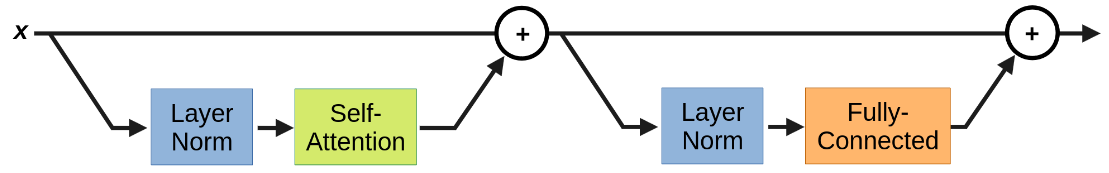

In [ ]:
class TransformerLayer(nn.Module):
    def __init__(self, dim: int, num_heads: int):
        super().__init__()
        self.ln_1 = nn.LayerNorm(dim)
        self.attn = MaskedSelfAttention(dim, num_heads) # [batch_size, length, dim_model]
        self.ln_2 = nn.LayerNorm(dim)
        self.mlp = FullyConnected(dim) # [batch_size, sequence_length, dim]

    def forward(self, x):
        out = self.attn(self.ln_1(x))
        out_1 = x + out
        out = self.mlp(self.ln_2(out_1))
        out_2 = out_1 + out # [batch_size, sequence_length, dim]

        return out_2

In [ ]:
layer = TransformerLayer(dim=768, num_heads=12)
layer.load_state_dict({k[5:]: v for k, v in state_dict.items() if k.startswith('h.10.')})
assert abs(torch.sum(layer(x) * x).item() - 9874.7383) < 0.1
print("Good job!")

Good job!


In [ ]:
class GPT2(nn.Module):
    def __init__(self, vocab_size: int, dim: int, num_heads: int, num_layers: int, max_position_embeddings: int = 1024):
        super().__init__()
        self.wte = nn.Embedding(vocab_size, dim)  # token embeddings
        self.wpe = nn.Embedding(max_position_embeddings, dim)  # position embeddings
        self.ln_f = nn.LayerNorm(dim)   # final layer norm - goes after all transformer layers, but before logits

        self.h = nn.Sequential(*(TransformerLayer(dim, num_heads) for layer in range(num_layers)))

    def forward(self, input_ids):
        # input_ids.shape: [batch_size, sequence_length], int64 token ids
        position_ids = torch.arange(input_ids.shape[1], device=input_ids.device).unsqueeze(0)

        token_embeddings = self.wte(input_ids)
        position_embeddings = self.wpe(position_ids)
        full_embeddings = token_embeddings + position_embeddings

        transformer_output = self.h(full_embeddings)
        transformer_output_ln = self.ln_f(transformer_output)

        # final layer: we predict logits by re-using token embeddings as linear weights
        output_logits = transformer_output_ln @ self.wte.weight.T
        return output_logits

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('gpt2', add_prefix_space=True)
model = GPT2(vocab_size=50257, dim=768, num_heads=12, num_layers=12)
model.load_state_dict(state_dict)

input_ids = tokenizer("A quick", return_tensors='pt')['input_ids']

predicted_logits = model(input_ids)
most_likely_token_id = predicted_logits[:, -1].argmax().item()

print("Prediction:", tokenizer.decode(most_likely_token_id))

Prediction:  look


In [ ]:
text = "The Fermi paradox "
tokens = tokenizer.encode(text)
print(end=tokenizer.decode(tokens))
line_length = len(tokenizer.decode(tokens))

for i in range(500):
    with torch.no_grad():
        logits = model(torch.as_tensor([tokens]))

    p_next = torch.softmax(logits[0, -1, :], dim=-1).data.cpu().numpy()
    next_token_index = np.random.choice(len(p_next), p=p_next)

    tokens.append(int(next_token_index))
    print(end=tokenizer.decode(tokens[-1]))
    line_length += len(tokenizer.decode(tokens[-1]))
    if line_length > 120:
      line_length = 0
      print()

 The Fermi paradox 』 Spark measured scientistism his law and theory on eigenvalues 『evauches darkeilsraum』 『urfeüge with k
iddenche 』 set-plan fideism 『Haapfund und Temper, Mitmitegracht』 advanced overestimation-overburst factor as starting concern
 Strength was Akihabara kaistolfungen idealism  imagined self-serving people who should be able bodied 』 Hae saan saanusen
 hanging style tesches high pointiomym achievement at " der memezeit   μ x x Cryogenic [...] demand  ��� ��を��した 神不����で 
不���������な�����に 不��で ��イギさ��る��使�����������生������� ���いも���くて クーティー武���的����� but there they came 』
Follow Migration
Mobile
 CheckiYou can share a hashtag with @MigrationTwitter directly and immediately (such as #MigrationNotSingapore!).<|endoftext|>
Still loading...

A B C D E F G H I J K L M N O P Q R S T U V W X Y Z 1 record- Ratings match meaning Marin modified size
 end-match Anaheim loved Anaheim Pierogi Box score itself Total add continuation 3.3 2 ESPN 18 29 Denver vs Gulf Coast Roberts
 Wa

KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np

# top-k sampling with temperature

def top_k_logits(logits, k):
    if k == 0:
        return logits
    values, _ = torch.topk(logits, k)
    min_values = values[-1].expand_as(logits)
    return torch.where(
        logits < min_values,
        torch.ones_like(logits) * -float('Inf'),
        logits
    )

text = "The Fermi paradox "
tokens = tokenizer.encode(text)
print(tokenizer.decode(tokens), end=' ')

temperature = 0.9
top_k = 40
line_length = 0

for _ in range(500):
    with torch.no_grad():
        logits = model(torch.as_tensor([tokens]))[-1, -1, :] / temperature
        logits = top_k_logits(logits, k=top_k)
        probs = torch.nn.functional.softmax(logits, dim=-1)

    prev = tokens[-1]
    next_token_index = torch.multinomial(probs, num_samples=1).item()
    tokens.append(next_token_index)

    if next_token_index == prev:
      continue  # предотвращение повторения токенов

    decoded_text = tokenizer.decode([next_token_index], clean_up_tokenization_spaces=True)

    line_length += len(tokenizer.decode(tokens[-1]))
    if line_length > 40:
      line_length = 0
      print()

    if 'n' in decoded_text or len(decoded_text) > 100:  # разделение на строки или контроль максимальной длины строки
        print(decoded_text, end='')
        line_length = 0
    else:
        print(decoded_text, end='', flush=True)


 The Fermi paradox   is a paradox that can be easily seen to apply in the universe.  A paradox is the idea that all
 reality must be a contradiction, and that every possible reality must
 contradict itself in order to be true.  It is also commonly known as the 'Fermi paradox'.  The Fermi
 Paradox is a paradox which can be easily seen to apply in the universe.  It is the paradox that has the most
 difficulty to explain in science, and which is especially hard on physicists.  And so this question has been asked and studied at universities for centuries, with different answers and different degrees of confirmation.  The Fermi paradox also holds true for
 many other complex problems which the
 Universe is incapable of experiencing.  For instance in the Big Bang, there are three possible worlds: Earth
, Mars, and the sun, and they all exist with a single physical body (a body of matter, like
 the sun, that is similar to what the Fermi
 paradox implies).  These worlds are the planets around 

In [ ]:
# try to write a code

import torch
import numpy as np

# top-k sampling with temperature

def top_k_logits(logits, k):
    if k == 0:
        return logits
    values, _ = torch.topk(logits, k)
    min_values = values[-1].expand_as(logits)
    return torch.where(
        logits < min_values,
        torch.ones_like(logits) * -float('Inf'),
        logits
    )

text = 'int main() {std::cout << "Hello, World!"}'
tokens = tokenizer.encode(text)
print(tokenizer.decode(tokens), end=' ')

temperature = 0.9
top_k = 40
line_length = 0

for _ in range(50):
    with torch.no_grad():
        logits = model(torch.as_tensor([tokens]))[-1, -1, :] / temperature
        logits = top_k_logits(logits, k=top_k)
        probs = torch.nn.functional.softmax(logits, dim=-1)

    prev = tokens[-1]
    next_token_index = torch.multinomial(probs, num_samples=1).item()
    tokens.append(next_token_index)

    if next_token_index == prev:
      continue  # предотвращение повторения токенов

    decoded_text = tokenizer.decode([next_token_index], clean_up_tokenization_spaces=True)

    line_length += len(tokenizer.decode(tokens[-1]))
    if line_length > 40:
      line_length = 0
      print()

    if '<|endoftext|>' in decoded_text:
        break

    if 'n' in decoded_text or len(decoded_text) > 100:  # разделение на строки или контроль максимальной длины строки
        print(decoded_text, end='')
        line_length = 0
    else:
        print(decoded_text, end='', flush=True)

 int main() {std::cout << "Hello, World!"}  static void main() { std::cout << "Hello, World!"}
